# Ceres Solver Python Tutorial

[READ THIS FIRST](https://andrewtorgesen.com/notes/Autonomy/Systems_Implementation/Optimization_Libraries/Ceres_Solver_Python_Tutorial.html)

Incrementally harder estimation problems solved with Python bindings to the Ceres Solver library.

## Outline

- [Hello World](#Hello-World)
- [1D SLAM with Range Measurements](#1D-SLAM-with-Range-Measurements)
- [Rotation Averaging with Quaternions and AutoDiff](#Rotation-Averaging-with-Quaternions-and-AutoDiff)
- [Pose Graph SLAM](#Pose-Graph-SLAM)
- [Pose Graph SLAM with Range Measurements](#Pose-Graph-SLAM-with-Range-Measurements)

## Running the Python Demo

If you wish to run/modify the demo yourself (outside of this Nix-based scratchpad environment), you’ll need to install these Python packages:

  * numpy
    * For working with vectors and some basic linear algebra.
  * matplotlib
    * For visualization.
  * [ceres_python_bindings](https://github.com/Edwinem/ceres_python_bindings)$^*$
    * Third-party Python bindings for Ceres **< 2.1.0**. Provides the core library API discussed above.
  * [geometry](https://github.com/goromal/geometry)$^*$
    * Python bindings for a C$++$ templated library that implements the chart map operations for $SO(3)$ and $SE(3)$. With this library, the $\oplus$ and $\ominus$ operators are abstracted away into the normal plus and minus operators.
  * [pyceres_factors](https://github.com/goromal/pyceres_factors)$^*$
    * Python bindings for custom cost functions for Ceres that make use of the geometry package above.

## Hello World

This isn't really a robotics problem--it's the Python-wrapped version of Ceres' [hello world tutorial](http://ceres-solver.org/nnls_tutorial.html#hello-world), where the goal is to minimize the cost function

$$J(x)=\frac{1}{2}(10-x)^2.$$

In [1]:
import PyCeres # Import the Python Bindings
import numpy as np

# The variable to solve for with its initial value.
initial_x = 5.0
x = np.array([initial_x]) # Requires the variable to be in a numpy array

# Here we create the problem as in normal Ceres
problem = PyCeres.Problem()

# Creates the CostFunction. This example uses a C++ wrapped function which 
# returns the Autodiffed cost function used in the C++ example
cost_function = PyCeres.CreateHelloWorldCostFunction()

# Add the costfunction and the parameter numpy array to the problem
problem.AddResidualBlock(cost_function, None, x) 

# Setup the solver options as in normal ceres
options=PyCeres.SolverOptions()
# Ceres enums live in PyCeres and require the enum Type
options.linear_solver_type = PyCeres.LinearSolverType.DENSE_QR
options.minimizer_progress_to_stdout = True
summary = PyCeres.Summary()
# Solve as you would normally
PyCeres.Solve(options, problem, summary)
print(summary.BriefReport() + " \n")
print( "x : " + str(initial_x) + " -> " + str(x) + "\n")

Ceres Solver Report: Iterations: 3, Initial cost: 1.250000e+01, Final cost: 1.388518e-16, Termination: CONVERGENCE 
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.250000e+01    0.00e+00    5.00e+00   0.00e+00   0.00e+00  1.00e+04        0    1.10e-05    4.51e-05
   1  1.249750e-07    1.25e+01    5.00e-04   5.00e+00   1.00e+00  3.00e+04        1    1.31e-05    8.32e-05
   2  1.388518e-16    1.25e-07    1.67e-08   5.00e-04   1.00e+00  9.00e+04        1    3.10e-06    9.11e-05

x : 5.00000000000000 -> [9.99999998]



## 1D SLAM with Range Measurements

In this simplified SLAM problem, a robot is moving along a line, obtaining noisy relative transform measurements $T$ and collecting noisy range measurements $z$ to three different landmarks. The cost function is the sum of all measurement residuals,

$$J(\hat{\boldsymbol{x}},\hat{\boldsymbol{l}})=\sum_{i=1}^8\left(\lvert\lvert T_i-\hat{T}_i\rvert\rvert_{\sigma_T}^2+\sum_{j=1}^3\lvert\lvert z_{i,j}-\hat{z}_{i,j}\rvert\rvert_{\sigma_z}^2\right),$$

for all states $\boldsymbol{x}$ and landmarks $\boldsymbol{l}$ over eight time steps. In this case, since it's in one dimension, the relative transform and range measurements are both computed simply by subtracting two numbers--no need for vector math or local parameterizations. Note the definitions of the Transform1D and Range1D factors as cost objects with provided analytic derivatives. In the future, we'll try defining factors with the help of AutoDiff.

In [4]:
import PyCeres as ceres
import numpy as np

##
# 1D SLAM with range measurements
##

# "Between Factor" for 1D transform measurement
class Transform1DFactor(ceres.CostFunction):
    # factor initialized with a measurement and an associated variance
    def __init__(self, z, var):
        super().__init__()
        # set size of residuals and parameters
        self.set_num_residuals(1)
        self.set_parameter_block_sizes([1,1])
        # set internal factor variables
        self.transform = z
        self.var = var

    # computes the residual and jacobian from the factor and connected state edges
    def Evaluate(self, parameters, residuals, jacobians):
        # measurement residual compares estimated vs measured transform, scaled by
        # measurement belief
        xi = parameters[0][0]
        xj = parameters[1][0]
        residuals[0] = (self.transform - (xj - xi)) / self.var

        # jacobian of the residual w.r.t. the parameters
        if jacobians != None:
            if jacobians[0] != None:
                jacobians[0][0] = 1.0 / self.var
            if jacobians[1] != None:
                jacobians[1][0] = -1.0 / self.var

        return True

class Range1DFactor(ceres.CostFunction):
    def __init__(self, z, var):
        super().__init__()
        self.set_num_residuals(1)
        self.set_parameter_block_sizes([1,1])
        self.range = z
        self.var = var

    def Evaluate(self, parameters, residuals, jacobians):
        # measurement residual compares estimated vs measured distance to a
        # specific landmark, scaled by measurement belief
        l = parameters[0][0]
        x = parameters[1][0]
        residuals[0] = (self.range - (l - x)) / self.var

        if jacobians != None:
            if jacobians[0] != None:
                jacobians[0][0] = -1.0 / self.var
            if jacobians[1] != None:
                jacobians[1][0] = 1.0 / self.var

        return True

# optimization problem
problem = ceres.Problem()

# true state positions
x = np.array([0., 1., 2., 3., 4., 5., 6., 7.]) 
# true landmark positions
l = np.array([10., 15., 13.])

# faulty landmark position beliefs
lhat = np.array([11., 12., 15.])

# simulate noisy 1D state estimates and landmark measurements that will
# be added to the problem as factors
xhat = np.array([0., 0., 0., 0., 0., 0., 0., 0.])
mu, sigma = 0.0, 1.0 # for normal distribution scalable by variance
Tvar = 1.0e-3 # variance of transform measurement noise
rvar = 1.0e-5 # variance of range measurement noise
for i in range(x.size):
    if i > 0:
        # measured relative transform in 1D 
        That = x[i] - x[i-1] + np.random.normal(mu, sigma, 1).item() * np.sqrt(Tvar)
        # propagate frontend state estimate
        xhat[i] = xhat[i-1] + That
        # add between factor to problem
        problem.AddResidualBlock(Transform1DFactor(That, Tvar), None, xhat[i-1:i], xhat[i:i+1])

    for j in range(l.size):
        # measured range from robot pose i to landmark j
        zbar = l[j] - x[i] + np.random.normal(mu, sigma, 1).item() * np.sqrt(rvar)
        # add range factor to problem
        problem.AddResidualBlock(Range1DFactor(zbar, rvar), None, lhat[j:j+1], xhat[i:i+1])

# initial error, for reference
init_error = np.linalg.norm(x - xhat) + np.linalg.norm(l - lhat)

# set solver options
options = ceres.SolverOptions()
options.max_num_iterations = 25
options.linear_solver_type = ceres.LinearSolverType.DENSE_QR
options.minimizer_progress_to_stdout = True

# solve!
summary = ceres.Summary()
ceres.Solve(options, problem, summary)

# report results
# print(summary.FullReport())
final_error = np.linalg.norm(x - xhat) + np.linalg.norm(l - lhat)
print('Total error of optimized states and landmarks: %f -> %f' % (init_error, final_error))

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.601406e+11    0.00e+00    2.39e+11   0.00e+00   0.00e+00  1.00e+04        0    1.46e-03    1.48e-03
   1  7.300423e+05    5.60e+11    2.39e+07   3.74e+00   1.00e+00  3.00e+04        1    1.55e-03    3.06e-03
   2  7.244422e+05    5.60e+03    7.99e+02   3.74e-04   1.00e+00  9.00e+04        1    1.58e-03    4.64e-03
Total error of optimized states and landmarks: 3.833489 -> 0.036703


## Rotation Averaging with Quaternions and AutoDiff

### Problem Overview

This example introduces [optimization over the manifold](https://andrewtorgesen.com/notes/Autonomy/Search_and_Optimization/Optimization_Over_Lie_Groups.html) of quaternions, as well as auto-differentiation in Ceres. The cost function simply consists of the residual between a single estimated quaternion and $N$ randomly-dispersed quaternions:

$$J(\hat{\boldsymbol{q}})=\sum_{i=1}^N\lvert\lvert \boldsymbol{q}_i\ominus\hat{\boldsymbol{q}}\rvert\rvert_2^2.$$

### Preliminary Class Definitions

From here on out, the derivatives get annoying enough that we will make exclusive use of AutoDiff to calculate our cost function Jacobians. Because the Python bindings don't provide helpful tools for defining an auto-differentiated cost function in Python, the local parameterization and cost function must be implemented in C++ and then wrapped in a Python constructor. Luckily, these C++ classes are already implemented for rotations (implemented on the $SO(3)$ manifold) and rigid body transformations (implemented on the $SE(3)$ manifold) in the [ceres-factors](https://github.com/goromal/ceres-factors) library with corresponding [Python wrappers](https://github.com/goromal/pyceres_factors). Check out the ceres-factors library to get a sense of how these classes are implemented, if you're interested.

### Optimization Routine

For the main Ceres solver code, we'll actually allow for the option to *not* define a special LocalParameterization for the quaternion decision variable, just so we can see how it affects the solution. When no LocalParameterization is given, Ceres will assume that the parameter is just a regular vector, and so will perform operations that will inevitably make the parameter leave the manifold it's supposed to be constrained to.

With `LOCAL_PARAMETERIZATION` set to `True`, the output will correspond to a normalized quaternion:

In [6]:
import numpy as np
from geometry import SO3
import PyCeres as ceres
import PyCeresFactors as factors

##
# Rotation Averaging with Quaternions
##

# If false, will treat the quaternion decision variable as a vector
LOCAL_PARAMETERIZATION = True

# number of rotations to average over
N = 1000
# scaling factor for noisy rotations
noise_scale = 1e-2
# represent the noise as a covariance matrix for the estimator
Q = np.sqrt(noise_scale) * np.eye(3)

# true average quaternion
q = SO3.random()

# initial vector guess for average quaternion
xhat = SO3.identity().array()

# optimization problem
problem = ceres.Problem()

# if using local parameterization, add it to the problem
if LOCAL_PARAMETERIZATION:
    problem.AddParameterBlock(xhat, 4, factors.SO3Parameterization())

# create noisy rotations around the true average and add to problem as 
# measurement residuals
for i in range(N):
    sample = (q + np.random.random(3) * noise_scale).array()
    problem.AddResidualBlock(factors.SO3Factor(sample, Q),
                             None,
                             xhat)

# set solver options
options = ceres.SolverOptions()
options.max_num_iterations = 25
options.linear_solver_type = ceres.LinearSolverType.DENSE_QR
options.minimizer_progress_to_stdout = True

# solve!
summary = ceres.Summary()
ceres.Solve(options, problem, summary)

# report results
q_hat = SO3(xhat)
print('q:', q)
print('q_hat:', q_hat)
if not LOCAL_PARAMETERIZATION:
    print('q_hat (normalized):', q_hat.normalized())

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.015570e+05    0.00e+00    1.08e+00   0.00e+00   0.00e+00  1.00e+04        0    7.06e-04    7.86e-04
   1  1.270696e+00    2.02e+05    5.94e-01   9.62e-01   1.00e+00  3.00e+04        1    9.57e-04    1.77e-03
   2  1.267216e+00    3.48e-03    4.03e-04   1.32e-04   1.00e+00  9.00e+04        1    7.85e-04    2.57e-03
q: SO(3): [ 0.538050, -0.523022i, 0.510656j, 0.419737k ]
q_hat: SO(3): [ 0.537031, -0.521410i, 0.514359j, 0.418527k ]


If `LOCAL_PARAMETERIZATION` is set to `False`, then an output similar to the following will be shown. Note that quaternion normalization is needed to actually return a valid answer. It even takes more iterations to converge!

In [7]:
import numpy as np
from geometry import SO3
import PyCeres as ceres
import PyCeresFactors as factors

##
# Rotation Averaging with Quaternions
##

# If false, will treat the quaternion decision variable as a vector
LOCAL_PARAMETERIZATION = False

# number of rotations to average over
N = 1000
# scaling factor for noisy rotations
noise_scale = 1e-2
# represent the noise as a covariance matrix for the estimator
Q = np.sqrt(noise_scale) * np.eye(3)

# true average quaternion
q = SO3.random()

# initial vector guess for average quaternion
xhat = SO3.identity().array()

# optimization problem
problem = ceres.Problem()

# if using local parameterization, add it to the problem
if LOCAL_PARAMETERIZATION:
    problem.AddParameterBlock(xhat, 4, factors.SO3Parameterization())

# create noisy rotations around the true average and add to problem as 
# measurement residuals
for i in range(N):
    sample = (q + np.random.random(3) * noise_scale).array()
    problem.AddResidualBlock(factors.SO3Factor(sample, Q),
                             None,
                             xhat)

# set solver options
options = ceres.SolverOptions()
options.max_num_iterations = 25
options.linear_solver_type = ceres.LinearSolverType.DENSE_QR
options.minimizer_progress_to_stdout = True

# solve!
summary = ceres.Summary()
ceres.Solve(options, problem, summary)

# report results
q_hat = SO3(xhat)
print('q:', q)
print('q_hat:', q_hat)
if not LOCAL_PARAMETERIZATION:
    print('q_hat (normalized):', q_hat.normalized())

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.436479e+05    0.00e+00    3.07e+05   0.00e+00   0.00e+00  1.00e+04        0    6.69e-04    7.45e-04
   1  1.448619e+04    2.29e+05    5.36e+04   1.10e+00   9.41e-01  3.00e+04        1    7.67e-04    1.54e-03
   2  1.000258e+01    1.45e+04    1.61e+03   4.07e-01   9.99e-01  9.00e+04        1    6.37e-04    2.19e-03
   3  1.246382e+00    8.76e+00    6.51e-01   9.76e-03   1.00e+00  2.70e+05        1    6.40e-04    2.83e-03
   4  1.246380e+00    1.44e-06    3.62e-06   3.99e-06   1.00e+00  8.10e+05        1    7.50e-04    3.59e-03
q: SO(3): [ 0.450897, 0.345360i, -0.622887j, 0.537988k ]
q_hat: SO(3): [ 0.662535, 0.505539i, -0.914198j, 0.796783k ]
q_hat (normalized): SO(3): [ 0.450263, 0.343567i, -0.621294j, 0.541498k ]


## Pose Graph SLAM

### Problem Overview

The pose graph SLAM problem aims to minimize the measurement error between measured and actual relative poses:

$$J=\sum_{(i,j)\in\mathcal{E}}\lvert\lvert \hat{\boldsymbol{R}}_{j}\ominus\hat{\boldsymbol{R}}_{i}\boldsymbol{R}_{ij}\rvert\rvert_{F}^{2}+\lvert\lvert \hat{\boldsymbol{t}}_{j}-\hat{\boldsymbol{t}}_{i}-\hat{\boldsymbol{R}}_{i}\boldsymbol{t}_{ij}\rvert\rvert_{2}^{2},$$

where the edges $\mathcal{E}$ in the pose graph encompass both odometry and loop closure relative pose measurements. With $\boldsymbol{T}\in SE(3)$ and adding in covariance matrix weighting, the above can be re-written concisely as

$$J=\sum_{(i,j)\in\mathcal{E}}\lvert\lvert \left(\hat{\boldsymbol{T}}_{i}^{-1}\hat{\boldsymbol{T}}_j\right)\ominus\boldsymbol{T}_{ij}\rvert\rvert_{\boldsymbol{\Sigma}}^{2}.$$

### Optimization Routine

Putting everything together, we simulate a simple robot moving in a circle, obtaining noisy odometry and loop closure measurements as it moves along. These noisy measurements are used to formulate and solve the pose graph optimization problem. We will generate a quick plot of the trajectories for several covariance and simulation parameter combinations gives a more intuitive evaluative measure:

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.005277e+07    0.00e+00    2.09e+00   0.00e+00   0.00e+00  1.00e+04        0    2.09e-04    3.27e-04
   1  1.478803e+05    7.99e+07    3.38e+02   8.95e+00   9.98e-01  3.00e+04        1    5.97e-04    9.42e-04
   2  1.981634e+03    1.46e+05    1.94e+02   3.18e+00   9.99e-01  9.00e+04        1    4.51e-04    1.40e-03
   3  1.543208e+03    4.38e+02    1.34e+01   3.78e+00   1.00e+00  2.70e+05        1    4.64e-04    1.87e-03
   4  1.327415e+03    2.16e+02    1.99e+00   6.59e+00   1.00e+00  8.10e+05        1    4.90e-04    2.37e-03
   5  1.147232e+03    1.80e+02    2.24e+00   9.71e+00   1.00e+00  2.43e+06        1    4.77e-04    2.85e-03
   6  1.075380e+03    7.19e+01    5.34e+00   1.06e+01   1.00e+00  7.29e+06        1    4.49e-04    3.31e-03
   7  1.047632e+03    2.77e+01    4.96e+00   1.52e+01   1.00e+00  2.19e+07        1    4.55e-04    3.77e-03
   8  1.036640e+03    1.10e+

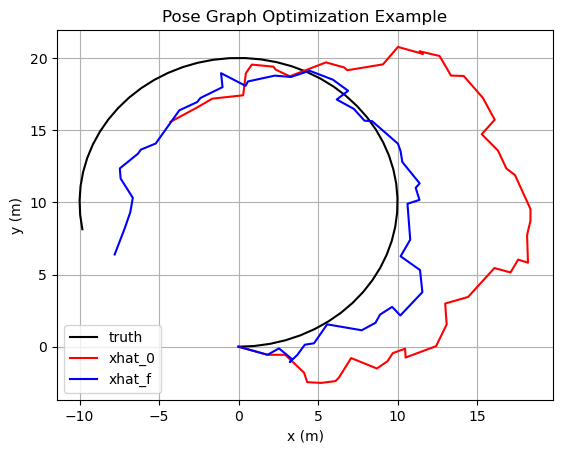

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from geometry import SE3
import PyCeres as ceres
import PyCeresFactors as factors

##
# Pose Graph SLAM
##

# odom, loop closure covariances (linear, angular)
odom_cov_vals = (0.5, 0.01)
lc_cov_vals = (0.001, 0.0001)

# simulation parameters
num_steps = 50
num_lc = 12 # number of loop closures to insert

# delta pose/odometry between successive nodes in graph (tangent space representation as a local perturbation)
dx = np.array([1.,0.,0.,0.,0.,0.1])

# odometry covariance
odom_cov = np.eye(6)
odom_cov[:3,:3] *= odom_cov_vals[0] # delta translation noise
odom_cov[3:,3:] *= odom_cov_vals[1] # delta rotation noise
odom_cov_sqrt = np.linalg.cholesky(odom_cov)

# loop closure covariance
lc_cov = np.eye(6)
lc_cov[:3,:3] *= lc_cov_vals[0] # relative translation noise
lc_cov[3:,3:] *= lc_cov_vals[1] # relative rotation noise
lc_cov_sqrt = np.linalg.cholesky(lc_cov)

# truth/estimate buffers
x = list()
xhat = list() # in Python, need to keep parameter arrays separate to prevent memory aliasing

# determine which pose indices will have loop closures between them
loop_closures = list()
for l in range(num_lc):
    i = np.random.randint(low=0, high=num_steps-1)
    j = np.random.randint(low=0, high=num_steps-2)
    if j == i:
        j = num_steps-1
    loop_closures.append((i,j))

# optimization problem
problem = ceres.Problem()

# create odometry measurements
for k in range(num_steps):
    if k == 0:
        # starting pose
        xhat.append(SE3.identity().array())
        x.append(SE3.identity().array())

        # add (fixed) prior to the graph
        problem.AddParameterBlock(xhat[k], 7, factors.SE3Parameterization())
        problem.SetParameterBlockConstant(xhat[k])
    else:
        # time step endpoints
        i = k-1
        j = k

        # simulate system
        x.append((SE3(x[i]) + dx).array())

        # create noisy front-end measurement (constrained to the horizontal plane)
        dx_noise = odom_cov_sqrt.dot(np.random.normal(np.zeros(6), np.ones(6), (6,)))
        dx_noise[2] = dx_noise[3] = dx_noise[4] = 0.
        dxhat = SE3.Exp(dx + dx_noise)
        xhat.append((SE3(xhat[i]) * dxhat).array())

        # add relative measurement to the problem as a between factor (with appropriate parameterization)
        problem.AddParameterBlock(xhat[j], 7, factors.SE3Parameterization())
        problem.AddResidualBlock(factors.RelSE3Factor(dxhat.array(), odom_cov), None, xhat[i], xhat[j])

# create loop closure measurements
for l in range(num_lc):
    i = loop_closures[l][0]
    j = loop_closures[l][1]

    # noise-less loop closure measurement
    xi = SE3(x[i])
    xj = SE3(x[j])
    xij = xi.inverse() * xj

    # add noise to loop closure measurement (constrained to the horizontal plane)
    dx_noise = lc_cov_sqrt.dot(np.random.normal(np.zeros(6), np.ones(6), (6,)))
    dx_noise[2] = dx_noise[3] = dx_noise[4] = 0.
    dx_meas = xij + dx_noise

    # add relative measurement to the problem as a between factor
    problem.AddResidualBlock(factors.RelSE3Factor(dx_meas.array(), lc_cov), None, xhat[i], xhat[j])

# initial error, for reference
prev_err = 0.
x1_true = list()
x2_true = list()
x1_init = list()
x2_init = list()
for k in range(num_steps):
    prev_err += 1.0/6.0*np.linalg.norm(x[k] - xhat[k])**2
    x1_true.append(x[k][0])
    x2_true.append(x[k][1])
    x1_init.append(xhat[k][0])
    x2_init.append(xhat[k][1])
prev_err /= num_steps

# set solver options
options = ceres.SolverOptions()
options.max_num_iterations = 25
options.linear_solver_type = ceres.LinearSolverType.SPARSE_NORMAL_CHOLESKY
options.minimizer_progress_to_stdout = True

# solve!
summary = ceres.Summary()
ceres.Solve(options, problem, summary)

# report results
post_err = 0.
x1_final = list()
x2_final = list()
for k in range(num_steps):
    post_err += 1.0/6.0*np.linalg.norm(x[k] - xhat[k])**2
    x1_final.append(xhat[k][0])
    x2_final.append(xhat[k][1])
post_err /= num_steps
print('Average error of optimized poses: %f -> %f' % (prev_err, post_err))

# plot results
fig, ax = plt.subplots()
ax.plot(x1_true, x2_true, color='black', label='truth')
ax.plot(x1_init, x2_init, color='red', label='xhat_0')
ax.plot(x1_final, x2_final, color='blue', label='xhat_f')
ax.set_title('Pose Graph Optimization Example')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.legend()
ax.grid()
plt.show()

## Pose Graph SLAM with Range Measurements

### Problem Overview

For this final example, we add point-to-point range measurements for random pose pairs along the trajectory:

$$J=\sum_{(i,j)\in\mathcal{E}}\lvert\lvert \left(\hat{\boldsymbol{T}}_{i}^{-1}\hat{\boldsymbol{T}}_j\right)\ominus\boldsymbol{T}_{ij}\rvert\rvert_{\boldsymbol{\Sigma}}^{2}+\lvert\lvert \lvert\lvert \hat{\boldsymbol{t}}_{j}-\hat{\boldsymbol{t}}_{i}\rvert\rvert_2-r_{ij}\rvert\rvert_{\boldsymbol{\Sigma}}^2,$$

which isn't very realistic, but can be informative about the feasibility of a larger problem of utilizing inter-agent range measurements in a multi-agent SLAM scenario to reduce drift without relying heavily on inter-agent loop closure detection and communication. The *PyCeresFactors.RangeFactor* function wrapper implements this custom cost function.

### Optimization Routine

The Python code is very similar to the pure pose graph problem--just with added range measurement simulation and corresponding range factors. It looks like range measurements can indeed help keep front-end drift under control, despite the fact that they only provide 1D information embedded in 3D space!

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.777535e+08    0.00e+00    1.44e+05   0.00e+00   0.00e+00  1.00e+04        0    3.44e-04    4.82e-04
   1  2.173148e+06    5.76e+08    6.61e+03   2.61e+01   9.96e-01  3.00e+04        1    6.24e-04    1.13e-03
   2  8.886844e+03    2.16e+06    9.51e+02   6.53e+00   9.97e-01  9.00e+04        1    5.23e-04    1.66e-03
   3  1.257076e+03    7.63e+03    5.16e+02   8.31e+00   9.89e-01  2.70e+05        1    4.33e-04    2.10e-03
   4  7.182079e+02    5.39e+02    4.18e+02   9.02e+00   8.71e-01  4.57e+05        1    4.18e-04    2.52e-03
   5  6.158827e+02    1.02e+02    8.90e+02   5.81e+00   6.24e-01  4.64e+05        1    3.95e-04    2.92e-03
   6  5.423938e+02    7.35e+01    1.52e+02   2.93e+00   9.66e-01  1.39e+06        1    4.03e-04    3.32e-03
   7  5.347846e+02    7.61e+00    5.73e+01   2.67e+00   9.88e-01  4.17e+06        1    4.08e-04    3.73e-03
   8  5.339489e+02    8.36e-

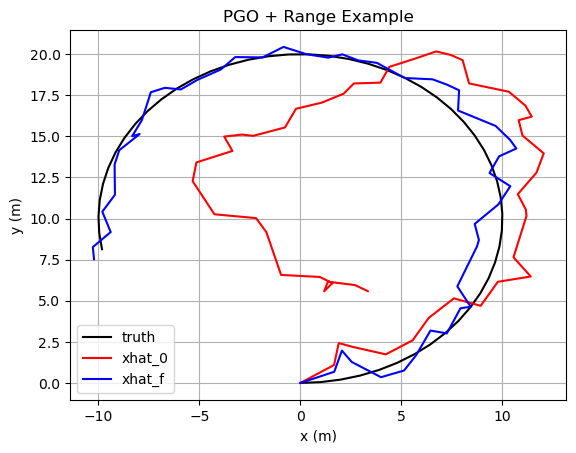

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from geometry import SE3
import PyCeres as ceres
import PyCeresFactors as factors

##
# Pose Graph SLAM with Range Measurements
##

# odom, loop closure covariances (linear, angular)
odom_cov_vals = (0.5, 0.01)
lc_cov_vals = (0.001, 0.0001)

# range variance
range_cov = 0.01

# simulation parameters
num_steps = 50
num_lc = 12
num_range = 12

# delta pose/odometry between successive nodes in graph (tangent space representation as a local perturbation)
dx = np.array([1.,0.,0.,0.,0.,0.1])

# odometry covariance
odom_cov = np.eye(6)
odom_cov[:3,:3] *= odom_cov_vals[0] # delta translation noise
odom_cov[3:,3:] *= odom_cov_vals[1] # delta rotation noise
odom_cov_sqrt = np.linalg.cholesky(odom_cov)

# loop closure covariance
lc_cov = np.eye(6)
lc_cov[:3,:3] *= lc_cov_vals[0] # relative translation noise
lc_cov[3:,3:] *= lc_cov_vals[1] # relative rotation noise
lc_cov_sqrt = np.linalg.cholesky(lc_cov)

# range covariance
range_cov_sqrt = np.sqrt(range_cov)

# truth/estimate buffers
x = list()
xhat = list() # in Python, need to keep parameter arrays separate to prevent memory aliasing

# determine which pose indices will have loop closures between them
loop_closures = list()
for l in range(num_lc):
    i = np.random.randint(low=0, high=num_steps-1)
    j = np.random.randint(low=0, high=num_steps-2)
    if j == i:
        j = num_steps-1
    loop_closures.append((i,j))

# determine which pose indices will have range measurements between them
range_measurements = list()
for l in range(num_range):
    i = np.random.randint(low=0, high=num_steps-1)
    j = np.random.randint(low=0, high=num_steps-2)
    if j == i:
        j = num_steps-1
    range_measurements.append((i,j))

# optimization problem
problem = ceres.Problem()

# create odometry measurements
for k in range(num_steps):
    if k == 0:
        # starting pose
        xhat.append(SE3.identity().array())
        x.append(SE3.identity().array())

        # add (fixed) prior to the graph
        problem.AddParameterBlock(xhat[k], 7, factors.SE3Parameterization())
        problem.SetParameterBlockConstant(xhat[k])
    else:
        # time step endpoints
        i = k-1
        j = k

        # simulate system
        x.append((SE3(x[i]) + dx).array())

        # create noisy front-end measurement (constrained to the horizontal plane)
        dx_noise = odom_cov_sqrt.dot(np.random.normal(np.zeros(6), np.ones(6), (6,)))
        dx_noise[2] = dx_noise[3] = dx_noise[4] = 0.
        dxhat = SE3.Exp(dx + dx_noise)
        xhat.append((SE3(xhat[i]) * dxhat).array())

        # add relative measurement to the problem as a between factor (with appropriate parameterization)
        problem.AddParameterBlock(xhat[j], 7, factors.SE3Parameterization())
        problem.AddResidualBlock(factors.RelSE3Factor(dxhat.array(), odom_cov), None, xhat[i], xhat[j])

# create loop closure measurements
for l in range(num_lc):
    i = loop_closures[l][0]
    j = loop_closures[l][1]

    # noise-less loop closure measurement
    xi = SE3(x[i])
    xj = SE3(x[j])
    xij = xi.inverse() * xj

    # add noise to loop closure measurement (constrained to the horizontal plane)
    dx_noise = lc_cov_sqrt.dot(np.random.normal(np.zeros(6), np.ones(6), (6,)))
    dx_noise[2] = dx_noise[3] = dx_noise[4] = 0.
    dx_meas = xij + dx_noise

    # add relative measurement to the problem as a between factor
    problem.AddResidualBlock(factors.RelSE3Factor(dx_meas.array(), lc_cov), None, xhat[i], xhat[j])

# create range measurements
for r in range(num_range):
    i = range_measurements[r][0]
    j = range_measurements[r][1]

    # noise-less range measurement
    ti = x[i][:3]
    tj = x[j][:3]
    rij = np.linalg.norm(tj - ti)

    # add noise to range measurement
    r_noise = range_cov_sqrt * np.random.normal(0.0, 1.0, 1).item()

    # add range measurement to the problem as a range factor
    problem.AddResidualBlock(factors.RangeFactor(rij, range_cov), None, xhat[i], xhat[j])

# initial error, for reference
prev_err = 0.
x1_true = list()
x2_true = list()
x1_init = list()
x2_init = list()
for k in range(num_steps):
    prev_err += 1.0/6.0*np.linalg.norm(x[k] - xhat[k])**2
    x1_true.append(x[k][0])
    x2_true.append(x[k][1])
    x1_init.append(xhat[k][0])
    x2_init.append(xhat[k][1])
prev_err /= num_steps

# set solver options
options = ceres.SolverOptions()
options.max_num_iterations = 25
options.linear_solver_type = ceres.LinearSolverType.SPARSE_NORMAL_CHOLESKY
options.minimizer_progress_to_stdout = True

# solve!
summary = ceres.Summary()
ceres.Solve(options, problem, summary)

# report results
post_err = 0.
x1_final = list()
x2_final = list()
for k in range(num_steps):
    post_err += 1.0/6.0*np.linalg.norm(x[k] - xhat[k])**2
    x1_final.append(xhat[k][0])
    x2_final.append(xhat[k][1])
post_err /= num_steps
print('Average error of optimized poses: %f -> %f' % (prev_err, post_err))

# plot results
fig, ax = plt.subplots()
ax.plot(x1_true, x2_true, color='black', label='truth')
ax.plot(x1_init, x2_init, color='red', label='xhat_0')
ax.plot(x1_final, x2_final, color='blue', label='xhat_f')
ax.set_title('PGO + Range Example')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.legend()
ax.grid()
plt.show()

For an additional example, check out [a 2D range and bearing fusion problem](./range_bearing_fusion.ipynb).